<a href="https://colab.research.google.com/github/Masaki0110/ds2wsCode/blob/main/ds2ws.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas torch transformers[sentencepiece] matplotlib fugashi mecab-python3 unidic-lite tweepy japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 64.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

感情分析モデルをロードします...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/924 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/509 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cpu


モデルのロードが完了しました。

クエリ「#参院選2025」(2025-07-20 11:00~2025-07-20 12:00 UTC)でツイートを収集中...
  -> 30件のツイートを収集しました。
  -> 30件のテキストを感情分析中...
「「#参院選2025」の感情分析結果
(夜 (20:00-21:00))」のグラフを作成中...


/tmp/ipython-input-2-1201213846.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{x:.0f}%' for x in ax.get_yticks()])


グラフを `sentiment_参院選2025_夜.png` として保存しました。


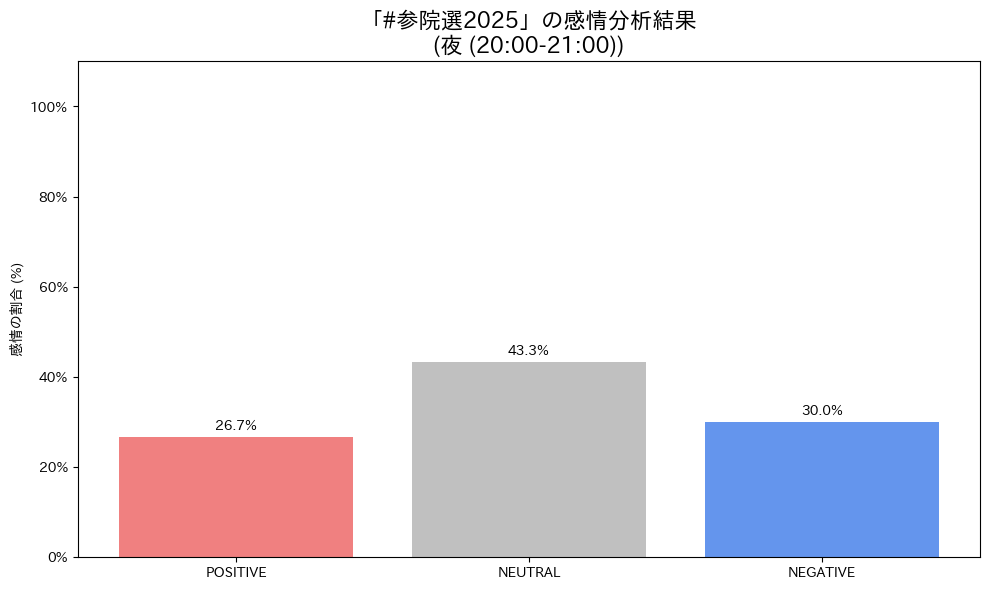

In [2]:
import pandas as pd
import re
import tweepy
from google.colab import userdata
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime, timedelta, timezone
import japanize_matplotlib # 日本語フォントを有効化

# --- ▼▼▼ 設定項目 ▼▼▼ ---
# 実行ごとに、ここを書き換えてください

# 1. 分析したいクエリ
SEARCH_QUERY = "#参院選2025"  # または "参政党"

# 2. 分析したい時間帯（日本時間で指定）
TIME_SLOT_NAME = "夜 (20:00-21:00)"
START_TIME_JST_STR = "2025-07-20 20:00:00"
END_TIME_JST_STR = "2025-07-20 21:00:00"

# --- ▲▲▲ 設定はここまで ▲▲▲ ---


# -----------------------------------------------------------------
# 1. データ収集 (X API v2を使用)
# -----------------------------------------------------------------
def collect_tweets(bearer_token, query, start_time_utc, end_time_utc, max_results=100):
    print(f"クエリ「{query}」({start_time_utc.strftime('%Y-%m-%d %H:%M')}~{end_time_utc.strftime('%Y-%m-%d %H:%M')} UTC)でツイートを収集中...")
    try:
        client = tweepy.Client(bearer_token)
        response = client.search_recent_tweets(
            query=f"{query} -is:retweet lang:ja",
            start_time=start_time_utc,
            end_time=end_time_utc,
            tweet_fields=["created_at", "text"],
            max_results=max_results
        )
        if not response.data:
            print("  -> ツイートが見つかりませんでした。")
            return pd.DataFrame()
        tweets = [{'text': tweet.text} for tweet in response.data]
        df = pd.DataFrame(tweets)
        print(f"  -> {len(df)}件のツイートを収集しました。")
        return df
    except Exception as e:
        print(f"  -> データ収集中にエラーが発生しました: {e}")
        return pd.DataFrame()

# -----------------------------------------------------------------
# 2. データ前処理
# -----------------------------------------------------------------
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    emoji_pattern = re.compile(f"[{''.join(map(chr, range(0x1F600, 0x1F650)))}]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = text.strip()
    return text

# -----------------------------------------------------------------
# 3. 感情分析
# -----------------------------------------------------------------
def analyze_sentiment_transformer(text_list, classifier):
    if not text_list:
        return []
    print(f"  -> {len(text_list)}件のテキストを感情分析中...")
    results = classifier(text_list, truncation=True, max_length=512, batch_size=32)
    return [result['label'] for result in results]

# -----------------------------------------------------------------
# 4. 可視化
# -----------------------------------------------------------------
def visualize_single_timeslot(results, title, filename):
    print(f"「{title}」のグラフを作成中...")
    labels = ['POSITIVE', 'NEUTRAL', 'NEGATIVE']
    ratios = [results.get(label, 0) for label in labels]
    colors = ['lightcoral', 'silver', 'cornflowerblue']

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(labels, ratios, color=colors)

    ax.set_ylabel('感情の割合 (%)')
    ax.set_title(title, fontsize=16)
    ax.set_ylim(0, 110)
    ax.set_yticklabels([f'{x:.0f}%' for x in ax.get_yticks()])
    ax.bar_label(bars, padding=3, fmt='%.1f%%')

    fig.tight_layout()
    plt.savefig(filename)
    print(f"グラフを `{filename}` として保存しました。")
    plt.show()

# =================================================================
# 5. メイン処理の実行
# =================================================================
if __name__ == "__main__":
    try:
        BEARER_TOKEN = userdata.get('BEARER_TOKEN')
    except userdata.SecretNotFoundError:
        print("エラー: Google Colabのシークレットに「BEARER_TOKEN」を設定してください。")
        BEARER_TOKEN = None

    if BEARER_TOKEN:
        jst = timezone(timedelta(hours=+9))
        start_jst = datetime.strptime(START_TIME_JST_STR, '%Y-%m-%d %H:%M:%S').replace(tzinfo=jst)
        end_jst = datetime.strptime(END_TIME_JST_STR, '%Y-%m-%d %H:%M:%S').replace(tzinfo=jst)

        start_utc = start_jst.astimezone(timezone.utc)
        end_utc = end_jst.astimezone(timezone.utc)

        print("感情分析モデルをロードします...")
        model_name = "koheiduck/bert-japanese-finetuned-sentiment"
        classifier = pipeline('sentiment-analysis', model=model_name, tokenizer=model_name, device=0 if torch.cuda.is_available() else -1)
        print("モデルのロードが完了しました。\n")

        # ▼▼▼ ここを変更 ▼▼▼
        df = collect_tweets(BEARER_TOKEN, SEARCH_QUERY, start_utc, end_utc, max_results=30) # 取得件数を30件に変更
        # ▲▲▲ ここを変更 ▲▲▲

        if not df.empty:
            df['cleaned_text'] = df['text'].apply(clean_text)
            texts = df[df['cleaned_text'].str.strip() != '']['cleaned_text'].tolist()

            if texts:
                sentiments = analyze_sentiment_transformer(texts, classifier)
                sentiment_counts = pd.Series(sentiments).value_counts()
                total_count = len(sentiments)
                sentiment_ratios = (sentiment_counts / total_count * 100).to_dict()

                graph_title = f"「{SEARCH_QUERY}」の感情分析結果\n({TIME_SLOT_NAME})"
                filename = f"sentiment_{SEARCH_QUERY.replace('#', '')}_{TIME_SLOT_NAME.split(' ')[0]}.png"
                visualize_single_timeslot(sentiment_ratios, graph_title, filename)
            else:
                print("分析可能なテキストが含まれていませんでした。")
        else:
            print("分析を終了します。")